## CIFAR 10

In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [10]:
from resources.conv_learner import *
import pickle
PATH = "../datasets/yeast_v4/"
os.makedirs(PATH,exist_ok=True)

In [11]:
def get_data(sz,bs):
    # load stats dictionary
    with open('./norm_stats.dict','rb') as file:
        stats = pickle.load(file)
    return ImageClassifierData.from_paths_and_stats(stats,sz,PATH, val_name='test',bs=bs)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

### Look at data

In [12]:
batch_size = 4
data = get_data(200, batch_size)

{'mfb1KO': (array([520.43242, 311.95407]), array([ 47.58622, 102.40188])), 'mfb1KO_mmr1KO': (array([517.82433, 310.53787]), array([ 47.79874, 100.2844 ])), 'mmr1KO': (array([522.00262, 315.86276]), array([ 49.22678, 110.97113])), 'WT': (array([521.95544, 310.77446]), array([48.37305, 95.64728]))}
{'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmr1KO': 3}
inited with dict: {1: (array([520.43242, 311.95407]), array([ 47.58622, 102.40188])), 2: (array([517.82433, 310.53787]), array([ 47.79874, 100.2844 ])), 3: (array([522.00262, 315.86276]), array([ 49.22678, 110.97113])), 0: (array([521.95544, 310.77446]), array([48.37305, 95.64728]))}


In [13]:
x,y=next(iter(data.trn_dl))

/home/user/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/cuda/__init__.py:97: UserWarning: 
    Found GPU0 GeForce GTX 960M which is of cuda capability 5.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [14]:
print(y)


 0
 3
 3
 0
[torch.cuda.LongTensor of size 4 (GPU 0)]



In [15]:
imdenorm = data.trn_ds.denorm(x, 1) #denorm function called has a rollaxis() hence indexing changes.

In [16]:
imdenorm.shape

(4, 200, 200, 2)

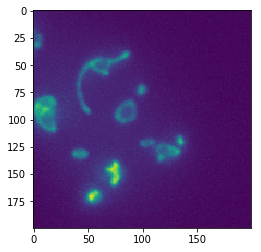

In [17]:
plt.imshow(imdenorm[0,:,:,1])

## Fully connected model

In [ ]:
data = get_data(200,bs)

In [ ]:
lr=1e-5

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40,2]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
learn.lr_find2()

In [ ]:
learn.sched.plot()

In [ ]:
%time learn.fit(lr, 2)

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

In [ ]:
learn.sched.plot()

## CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 2), data)

### .from_model_data triggers basicmodel() which forwards to a pytorch's .cuda function to run model on GPU. Hence 
### an explicit model.cuda is not necessary here.

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
learn.lr_find(end_lr=100)

In [ ]:
learn.sched.plot()

In [ ]:
%time learn.fit(1e-5, 2)

In [ ]:
%time learn.fit(1e-5, 4, cycle_len=1)

## Refactored

In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 2), data)

In [ ]:
learn.summary()

In [ ]:
%time learn.fit(1e-1, 2)

In [ ]:
%time learn.fit(1e-1, 2, cycle_len=1)

## BatchNorm

In [ ]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [ ]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2) #(!) changed 3 to 2
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 2), data)

In [ ]:
learn.summary()

In [ ]:
%time learn.fit(3e-2, 2)

In [ ]:
%time learn.fit(1e-4, 20, cycle_len=1)

In [ ]:
learn.save('tmp_batchNorm_aug')

## Deep BatchNorm

In [ ]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [ ]:
%time learn.fit(1e-2, 2)

In [ ]:
%time learn.fit(1e-2, 2, cycle_len=1)

## Resnet

In [ ]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [ ]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 2), data)

In [ ]:
wd=1e-5

In [ ]:
%time learn.fit(1e-5, 2, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-5, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learn.fit(1e-5, 20, cycle_len=4, wds=wd)

## Resnet 2

In [ ]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [ ]:
wd=1e-6

In [ ]:
%time learn.fit(1e-2, 2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.save('tmp4_clr')

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [ ]:
metrics.log_loss(y,preds), accuracy(preds,y)

In [ ]:
metrics.log_loss(y,preds)

### End